In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
cwd = os.getcwd()
base_path = os.path.abspath(os.path.join(cwd, '../../'))

## Fig.5 Integrative regulatory inference by model interpretability and pseudo-knockout

- Heatmap of attention matrix between RNA and protein.

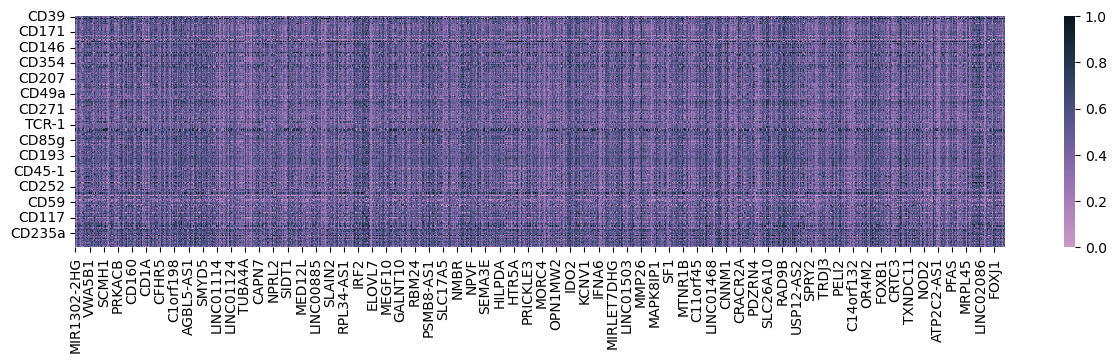

In [2]:
path = base_path+'/result/fig5/a/encoder2decoder_attention_score.csv'
weights = pd.read_csv(path, sep=',',index_col=0)

fig = plt.figure(figsize=(15,3))
color = sns.cubehelix_palette(16,start=2.5, rot=0.5, gamma=.9, dark=0.05, light=0.65, as_cmap=True)
sns.heatmap(weights.T, cmap=color)
plt.show()

- zoom in attention matrix obtained from encoder to decoder 

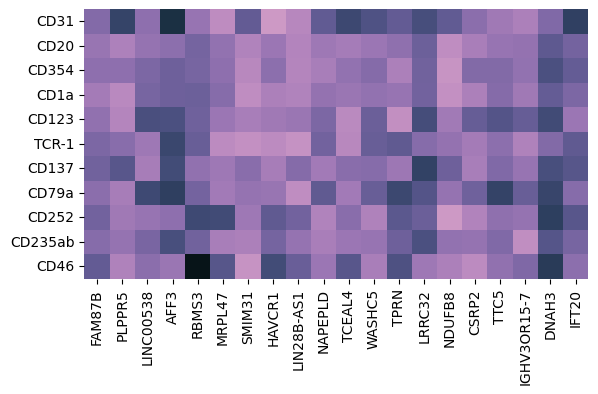

In [3]:
fig = plt.figure(figsize=(6.5,3.5))
n_g = 1000
n_p = 20
# sns.heatmap(weights.iloc[::n_g,::n_p].T, cmap=color, cbar=False)
sns.heatmap(weights.iloc[5::n_g,5::n_p].T, cmap=color, cbar=False)
plt.show()

- Potential regulation gene

In [4]:
percent = 0.05
regulation_gene = weights.sum(axis=1).sort_values(ascending=False).index[:int(weights.shape[0]*percent)]

- GRN

In [5]:
path = os.path.join(base_path, 'result/fig5/a/encoder_attention_score.csv')
enc_weights = pd.read_csv(path, sep=',', index_col=0)

target_proteins = ['STAT3', 'IRF4', 'FOXP3']

result_list = []
for protein in target_proteins:
    enc_weights_filtered = enc_weights.drop(columns=protein, errors='ignore')
    top_genes = enc_weights_filtered.loc[protein,:].nlargest(20)
    for gene, score in top_genes.items():
        result_list.append([protein, gene, score])
        
result_df = pd.DataFrame(result_list, columns=['TF', 'Gene', 'Attention Score'])
path = os.path.join(base_path, 'result/fig5/c/GRN.xlsx')
result_df.to_excel(path, index=False)
print(result_df)

       TF        Gene  Attention Score
0   STAT3        ODF3         1.000000
1   STAT3     SLC30A6         0.909990
2   STAT3       EXOC2         0.835076
3   STAT3     CCDC189         0.810703
4   STAT3       VAMP1         0.801102
5   STAT3   LINC02378         0.792640
6   STAT3      ARL17B         0.748191
7   STAT3       REG1A         0.747889
8   STAT3        FLT4         0.724389
9   STAT3     DCSTAMP         0.723804
10  STAT3       TTLL4         0.715181
11  STAT3       ESRRB         0.707988
12  STAT3      TRIM42         0.705961
13  STAT3       TONSL         0.702463
14  STAT3       OR9G1         0.696760
15  STAT3       SRPRB         0.696497
16  STAT3         CGN         0.694542
17  STAT3       PTRH2         0.690507
18  STAT3       RAMP3         0.687157
19  STAT3       MKRN1         0.686604
20   IRF4        SOX1         1.000000
21   IRF4     PHACTR1         0.951936
22   IRF4        GNLY         0.934286
23   IRF4       ZZEF1         0.928173
24   IRF4      ZBTB22    

## PPI

In [6]:
path = os.path.join(base_path, 'result/fig5/a/decoder_attention_score.csv')
dec_weights = pd.read_csv(path, sep=',', index_col=0)

target_proteins = ['CD8a', 'CD273', 'CD45RA']

result_list = []
for protein in target_proteins:
    dec_weights_filtered = dec_weights.drop(columns=protein, errors='ignore')
    top_genes = dec_weights_filtered.loc[protein,:].nlargest(23)
    for gene, score in top_genes.items():
        result_list.append([protein, gene, score])
        
result_df = pd.DataFrame(result_list, columns=['Protein A', 'Protein B', 'Attention Score'])
path = os.path.join(base_path, 'result/fig5/d/PPI.xlsx')
result_df.to_excel(path, index=False)
print(result_df)


   Protein A  Protein B  Attention Score
0       CD8a       CD1c         1.000000
1       CD8a      CD271         1.000000
2       CD8a       CD80         1.000000
3       CD8a      CD338         0.987884
4       CD8a       CD68         0.881016
..       ...        ...              ...
64    CD45RA       CD69         0.769143
65    CD45RA  TCR-V-7.2         0.767565
66    CD45RA      CD206         0.763793
67    CD45RA      B7-H4         0.762812
68    CD45RA     CD56-1         0.761120

[69 rows x 3 columns]


- Results of pseudo-knockout

In [7]:
path = base_path+'/result/fig5/e/knock_out_org.pkl'
org = pd.read_pickle(path)

Text(0, 0.5, 'Protein abundance changes')

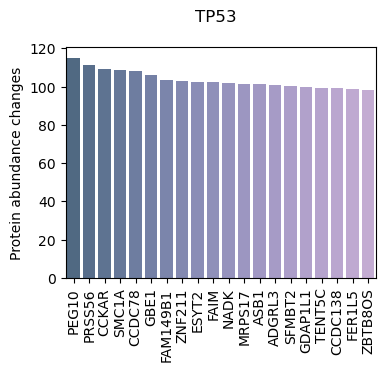

In [8]:
gene_index = 'TP53'
plt.rcParams['font.size'] = 10
path = base_path+'/result/fig5/e/knock_out_'+gene_index+'.pkl'
knocked = pd.read_pickle(path)

start, top_protein = 0, 20
delta = pd.DataFrame((knocked.sum()-org.sum()).values, columns=['org_value'], index=knocked.columns)
delta['abs_value'] = abs(delta['org_value'])

x = delta['abs_value'].sort_values(ascending=False).index[start:start+top_protein]
y = delta.loc[x,'abs_value']
fig = plt.figure(figsize=(4,3))
color = sns.cubehelix_palette(top_protein,start=2.5, rot=0.5, gamma=.5, dark=0.15, light=0.5, reverse=True)
ax = sns.barplot(x=x, y=y, palette=color)

ax.figure.suptitle(gene_index, verticalalignment='center')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.ylabel('Protein abundance changes')
